In [1]:
import yaml
import os
from pprint import pprint
from SmartAITool.core import bprint
# Load API configuration from a YAML file
with open("/home/rteam2/m15kh/LLM/config.yaml", "r") as file:
    config = yaml.safe_load(file)

os.environ["LANGSMITH_TRACING"] = config.get("LANGSMITH_TRACING", "false")
os.environ["LANGSMITH_API_KEY"] = config["LANGSMITH_API_KEY"]
os.environ["TAVILY_API_KEY"] = config["TAVILY_API_KEY"]
os.environ['HUGGINGFACEHUB_API_TOKEN'] = config['HUGGINGFACEHUB_API_TOKEN']
GPT_API_KEY = config['GPT_API_KEY']


In [2]:
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    api_key= GPT_API_KEY,
    base_url="https://api.gilas.io/v1/",
    model="gpt-4o-mini")



In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    api_key= GPT_API_KEY,
    base_url="https://api.gilas.io/v1/",
    model="text-embedding-3-large", dimensions=3072 )

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
print((vector_store))

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [6]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [8]:
pprint(all_splits[0:3])

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from

In [11]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

for i, split in enumerate(all_splits):
    num_tokens = len(encoding.encode(split.page_content))
    print(f"Split {i}: {num_tokens} tokens")


Split 0: 207 tokens
Split 1: 110 tokens
Split 2: 123 tokens
Split 3: 146 tokens
Split 4: 196 tokens
Split 5: 105 tokens
Split 6: 194 tokens
Split 7: 140 tokens
Split 8: 45 tokens
Split 9: 266 tokens
Split 10: 82 tokens
Split 11: 184 tokens
Split 12: 178 tokens
Split 13: 108 tokens
Split 14: 213 tokens
Split 15: 200 tokens
Split 16: 91 tokens
Split 17: 100 tokens
Split 18: 157 tokens
Split 19: 164 tokens
Split 20: 173 tokens
Split 21: 94 tokens
Split 22: 150 tokens
Split 23: 175 tokens
Split 24: 102 tokens
Split 25: 93 tokens
Split 26: 194 tokens
Split 27: 170 tokens
Split 28: 128 tokens
Split 29: 91 tokens
Split 30: 130 tokens
Split 31: 145 tokens
Split 32: 139 tokens
Split 33: 148 tokens
Split 34: 187 tokens
Split 35: 34 tokens
Split 36: 200 tokens
Split 37: 157 tokens
Split 38: 120 tokens
Split 39: 202 tokens
Split 40: 128 tokens
Split 41: 284 tokens
Split 42: 197 tokens
Split 43: 116 tokens
Split 44: 225 tokens
Split 45: 159 tokens
Split 46: 164 tokens
Split 47: 217 tokens
Split 48:

In [10]:
# Safely embed in batches of 1 to avoid exceeding total token limit per request
document_ids = []

for split in all_splits:
    ids = vector_store.add_documents(documents=[split])
    document_ids.extend(ids)


In [12]:
print(document_ids[:3])



['b40940bf-b572-4a16-a270-ba6d89080dfb', 'd2e288ba-3cd3-416e-8a0b-9f0be004a041', '159730dd-135e-445c-8ed4-261e3a7e8df2']


In [13]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

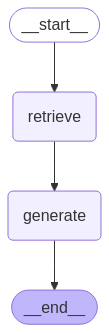

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='159730dd-135e-445c-8ed4-261e3a7e8df2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='ee4e24a8-d37c-4135-b68f-c8daa863d897', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

In [18]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='159730dd-135e-445c-8ed4-261e3a7e8df2', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='ee4e24a8-d37c-4135-b68f-c8daa863d897', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 202

In [19]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| manageable| steps|.| This| involves| utilizing| techniques| like| Chain| of| Thought| (|Co|T|)| to| guide| models| in| reasoning| step| by| step|,| thereby| simplifying| the| overall| task|.| It| can| be| executed| through| simple| prompts|,| task|-specific| instructions|,| or| human| inputs|.|||

In [20]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)